# Introduction

This notebook is basically a copy of the `brats_segmentation_3d.ipynb` notebook from https://github.com/Project-MONAI/tutorials. We will not have time for a detailed introduction to MONAI. Please consult the documentation: https://monai.io.

<img src="assets/brats-montage.png">

Our goal is to illustrate a possible approach to do brain tumor segmentation. I.e. extracting meaningful tumor regions, in this case "whole tumor", "tumor core" and "enhancing tumor". As discussed, this can give important imaging biomarkers as f.ex. volume, and also provide "region of interests" for extracting radiomics features.  

# Setup

In [1]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory, 
# as that makes some difference for the code below.
try:
    import colab
    colab=True
except:
    colab=False

In [2]:
if colab:
    !python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
    !python -c "import matplotlib" || pip install -q matplotlib
    !pip install fastcore

In [3]:
%matplotlib inline
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import sys
sys.path.append("../")

In [4]:
if colab:
    from google.colab import drive
    drive.mount("/content/gdrive")
    DATA = Path("/content/gdrive/MyDrive/Colab Notebooks/data/brats")
    DATA.mkdir(exist_ok=True)
else:
    # Point this to where you want to store and unzip the file `stage1_train.zip'
    DATA = Path.home()/'data-tmp'/'brats'
    DATA.mkdir(exist_ok=True, parents=True)

In [5]:
import os
import shutil
import tempfile

MONAI is based on PyTorch. You'll recognize some bits of this notebook from our previous discussion of PyTorch.

In [6]:
import torch

/home/alex/anaconda3/envs/monai/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Here's the MONAI stuff we'll need:

In [7]:
from monai.config import print_config

In [8]:
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    AsChannelFirstd,
    AsDiscrete,
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    ToTensord,
)
from monai.utils import set_determinism

In [10]:
from fastcore.utils import *

# Load data

In [11]:
path = DATA/'MONAI'
path.mkdir(exist_ok=True, parents=True)

In [12]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(np.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(
                np.logical_or(
                    np.logical_or(d[key] == 2, d[key] == 3), d[key] == 1
                )
            )
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d

In [13]:
batch_size = 4

In [14]:
train_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        RandSpatialCropd(
            keys=["image", "label"], roi_size=[128, 128, 64], random_size=False
        ),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=0.5),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=0.5),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
    ]
)

Here we load and cache the dataset (cached for more efficient training later). This takes a while... To lower system memory requirements, set `cache_num` to a number less than 388. If you run out of GPU memory you may as usual try lowering the batch size.

In [15]:
train_ds = DecathlonDataset(
    root_dir=path,
    task="Task01_BrainTumour",
    transform=train_transform,
    section="training",
    download=True,
    num_workers=4,
    #cache_num=100,
)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)

Task01_BrainTumour.tar: 7.09GB [14:41, 8.63MB/s]                                          

2022-05-12 08:31:08,477 - INFO - Downloaded: /home/alex/data-tmp/brats/MONAI/Task01_BrainTumour.tar


2022-05-12 08:31:23,925 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2022-05-12 08:31:23,926 - INFO - Writing into directory: /home/alex/data-tmp/brats/MONAI.


Loading dataset: 100%|██████████████████████████████████| 388/388 [04:37<00:00,  1.40it/s]


In [16]:
val_ds = DecathlonDataset(
    root_dir=path,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False,
    num_workers=4,
)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)

Loading dataset: 100%|████████████████████████████████████| 96/96 [01:10<00:00,  1.36it/s]


## Have a look at some data

Let's extract a sample from our training loader:

In [17]:
sample_data = next(enumerate(train_loader))

The MONAI data loaders have a specific structure:

In [18]:
sample_data[1].keys()

dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict', 'image_transforms', 'label_transforms'])

Per batch of 4 data points there are 4 images (T1, T1Gd, T2, FLAIR), each of the size (128, 128, 64) specified above:

In [19]:
sample_data[1]['image'].shape

torch.Size([4, 4, 128, 128, 64])

The same goes for the labels (i.e. the masks indicating the tumors):

In [20]:
sample_data[1]['label'].shape

torch.Size([4, 3, 128, 128, 64])

Additional image metadata is also available:

In [21]:
sample_data[1]['image_meta_dict']

{'sizeof_hdr': tensor([348, 348, 348, 348], dtype=torch.int32),
 'extents': tensor([0, 0, 0, 0], dtype=torch.int32),
 'session_error': tensor([0, 0, 0, 0], dtype=torch.int16),
 'dim_info': tensor([0, 0, 0, 0], dtype=torch.uint8),
 'dim': tensor([[  4, 240, 240, 155,   4,   1,   1,   1],
         [  4, 240, 240, 155,   4,   1,   1,   1],
         [  4, 240, 240, 155,   4,   1,   1,   1],
         [  4, 240, 240, 155,   4,   1,   1,   1]], dtype=torch.int16),
 'intent_p1': tensor([0., 0., 0., 0.]),
 'intent_p2': tensor([0., 0., 0., 0.]),
 'intent_p3': tensor([0., 0., 0., 0.]),
 'intent_code': tensor([0, 0, 0, 0], dtype=torch.int16),
 'datatype': tensor([16, 16, 16, 16], dtype=torch.int16),
 'bitpix': tensor([32, 32, 32, 32], dtype=torch.int16),
 'slice_start': tensor([0, 0, 0, 0], dtype=torch.int16),
 'pixdim': tensor([[1., 1., 1., 1., 1., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 0.]]),
 'vox_

Here are a few images:

In [22]:
sample_data[1]['image'].shape

torch.Size([4, 4, 128, 128, 64])

In [23]:
# First data set in the batch:
ims = sample_data[1]['image'][0]
lbls = sample_data[1]['label'][0]

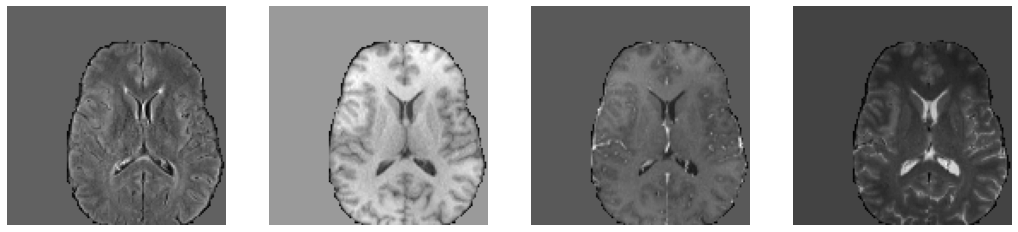

In [24]:
f, ax = plt.subplots(1,4, figsize=(18,6))
for i in range(4):
    ax[i].axis('off')
    ax[i].imshow(np.rot90(ims[i,:,:,32].detach().cpu()), cmap="gray")
plt.show()

Here are the labels overlayed on the first channel:

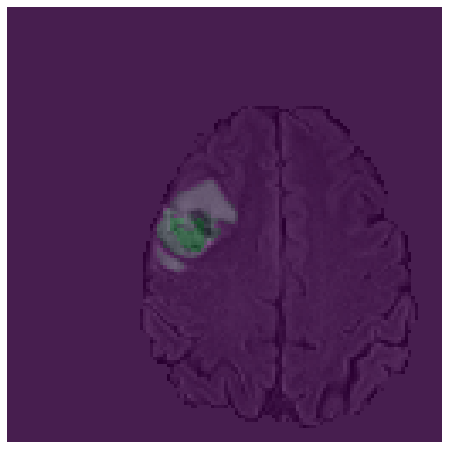

In [27]:
f = plt.figure(figsize=(8,8))

plt.imshow(np.rot90(ims[0,:,:,48].detach().cpu()), cmap="gray")

for i in range(3):
    plt.imshow(np.rot90(lbls[i,:,:,48].detach().cpu()), cmap='PRGn', alpha=0.3)

plt.axis('off')
plt.show()

# Create a model

Let's create a simple UNet model:

In [28]:
device = torch.device("cuda:0")
model = UNet(
    dimensions=3,
    in_channels=4,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    act='MISH'
).to(device)

In [29]:
loss_function = DiceLoss(to_onehot_y=False, sigmoid=True, squared_pred=True)

We'll use the 2021 version of the Ranger optimizer https://github.com/lessw2020/Ranger21:

In [30]:
import sys
!{sys.executable} -m pip install git+https://github.com/lessw2020/Ranger21.git

  Cloning https://github.com/lessw2020/Ranger21.git to /tmp/pip-req-build-ht0auczn
  Running command git clone --filter=blob:none --quiet https://github.com/lessw2020/Ranger21.git /tmp/pip-req-build-ht0auczn
  Resolved https://github.com/lessw2020/Ranger21.git to commit 1a96777278cdd14bc11afd865112724386d26a44
  Preparing metadata (setup.py) ... done
  Created wheel for ranger21: filename=ranger21-0.0.1-py3-none-any.whl size=24734 sha256=c92f5f21e986fe898f8e3cdfadfb259aa5603f715b285f249f9eba9135fc6777
  Stored in directory: /tmp/pip-ephem-wheel-cache-1zdyx5mu/wheels/ce/fa/a3/b9fb1d5b6129c81c852d06d951c3e9f5ce2b0dfa9ed4b5b455
Successfully built ranger21


In [31]:
max_epochs = 400

In [32]:
from ranger21 import Ranger21

In [33]:
optimizer = Ranger21(model.parameters(), lr=1e-3, num_epochs=max_epochs, 
                     num_batches_per_epoch=len(train_loader),
                    use_adaptive_gradient_clipping=False)

Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 400 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = False

Warm-down: Linear warmdown, starting at 72.0%, iteration 27936 of 38800
warm down will decay until 3e-05 lr


# Training loop

The following resembles the training loop from the first deep learning lecture. 

Warning: The model takes a long time to train (we will stop the training after a few epochs and not let it go all the way to the specified `max_epochs`. Feel free to train training for longer).. 

In [34]:
root_dir = path

In [65]:
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        if step%20 == 0:
            print(
                f"{step}/{len(train_ds) // train_loader.batch_size}"
                f", train_loss: {loss.item():.4f}"
            )
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            dice_metric = DiceMetric(include_background=True, reduction="mean", 
                                    get_not_nans=True)
            post_trans = Compose(
                [Activations(sigmoid=True), AsDiscrete(threshold_values=True)]
            )
            metric_sum = 0.0
            metric_count = 0
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = model(val_inputs)
                val_outputs = post_trans(val_outputs)
                # compute overall mean dice
                dm = dice_metric(y_pred=val_outputs, y=val_labels)
                value, not_nans = dice_metric.aggregate()
                not_nans = not_nans.item()
                metric_count += not_nans
                metric_sum += value.item() * not_nans
                

            metric = metric_sum / metric_count
            metric_values.append(metric)
            
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

----------
epoch 1/400
20/97, train_loss: 0.8411
40/97, train_loss: 0.8493
60/97, train_loss: 0.8018
80/97, train_loss: 0.7901
epoch 1 average loss: 0.8387
saved new best metric model
current epoch: 1 current mean dice: 0.2812
best mean dice: 0.2812 at epoch: 1
----------
epoch 2/400
20/97, train_loss: 0.8234
40/97, train_loss: 0.7578
60/97, train_loss: 0.9232
80/97, train_loss: 0.7791
epoch 2 average loss: 0.8155
saved new best metric model
current epoch: 2 current mean dice: 0.3127
best mean dice: 0.3127 at epoch: 2
----------
epoch 3/400
20/97, train_loss: 0.8847
40/97, train_loss: 0.7451
60/97, train_loss: 0.7023
80/97, train_loss: 0.8031
epoch 3 average loss: 0.7896
saved new best metric model
current epoch: 3 current mean dice: 0.3160
best mean dice: 0.3160 at epoch: 3
----------
epoch 4/400
20/97, train_loss: 0.8269
40/97, train_loss: 0.7088
60/97, train_loss: 0.8248
80/97, train_loss: 0.7812
epoch 4 average loss: 0.7617
saved new best metric model
current epoch: 4 current mean 

60/97, train_loss: 0.3681
80/97, train_loss: 0.2322
epoch 33 average loss: 0.2820
current epoch: 33 current mean dice: 0.6775
best mean dice: 0.6937 at epoch: 32
----------
epoch 34/400
20/97, train_loss: 0.3068
40/97, train_loss: 0.2447
60/97, train_loss: 0.2480
80/97, train_loss: 0.3485
epoch 34 average loss: 0.2798
current epoch: 34 current mean dice: 0.6840
best mean dice: 0.6937 at epoch: 32
----------
epoch 35/400
20/97, train_loss: 0.2371
40/97, train_loss: 0.3054
60/97, train_loss: 0.2488
80/97, train_loss: 0.2312
epoch 35 average loss: 0.2806
saved new best metric model
current epoch: 35 current mean dice: 0.6994
best mean dice: 0.6994 at epoch: 35
----------
epoch 36/400
20/97, train_loss: 0.2796
40/97, train_loss: 0.3149
60/97, train_loss: 0.2245
80/97, train_loss: 0.2029
epoch 36 average loss: 0.2779
current epoch: 36 current mean dice: 0.6976
best mean dice: 0.6994 at epoch: 35
----------
epoch 37/400
20/97, train_loss: 0.3204
40/97, train_loss: 0.2593
60/97, train_loss: 0

current epoch: 66 current mean dice: 0.7262
best mean dice: 0.7308 at epoch: 62
----------
epoch 67/400
20/97, train_loss: 0.1851
40/97, train_loss: 0.1614
60/97, train_loss: 0.3149
80/97, train_loss: 0.2261
epoch 67 average loss: 0.2167
current epoch: 67 current mean dice: 0.7122
best mean dice: 0.7308 at epoch: 62
----------
epoch 68/400
20/97, train_loss: 0.1978
40/97, train_loss: 0.2497
60/97, train_loss: 0.1930
80/97, train_loss: 0.0993
epoch 68 average loss: 0.2213


Exception ignored in: <function _releaseLock at 0x7f88c4ba8670>
Traceback (most recent call last):
  File "/home/alex/anaconda3/envs/monai/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


RuntimeError: DataLoader worker (pid(s) 278400) exited unexpectedly

> Note: we manually stopped the training before completion. Training the model longer would result in a better performing model.

In [66]:
print(
    f"train completed, best_metric: {best_metric:.4f}"
    f" at epoch: {best_metric_epoch}"
)


train completed, best_metric: 0.7308 at epoch: 62


Here are plots of the losses and metrics observed during training:

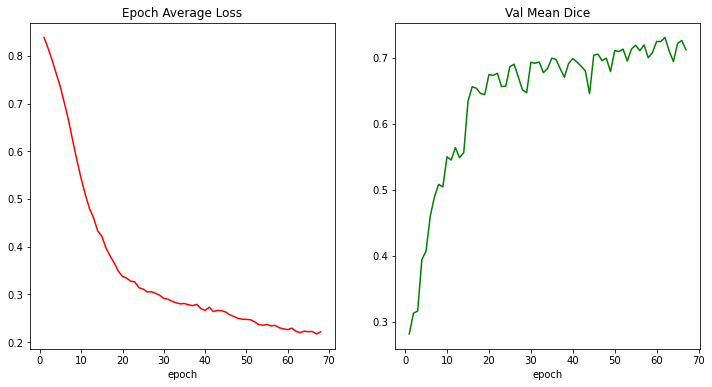

In [67]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

Here's a set of predictions for a few random validation data instances from the top performing model:

In [68]:
model.load_state_dict(
    torch.load(os.path.join(root_dir, "best_metric_model.pth"))
)
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): Mish()
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): Mish()
          )
        )
      )
      (residual): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit0): Con

In [69]:
import random

In [70]:
def plot_preds(ds):
    with torch.no_grad():
        # select one image to evaluate and visualize the model output
        val_input = val_ds[ds]["image"].unsqueeze(0).to(device)
        val_output = post_trans(model(val_input))
        plt.figure("image", (24, 6))
        for i in range(4):
            plt.subplot(1, 4, i + 1)
            plt.title(f"image channel {i}")
            plt.imshow(val_ds[ds]["image"][i, :, :, 20].detach().cpu(), cmap="gray")
        plt.show()
        # visualize the 3 channels label corresponding to this image
        plt.figure("label", (18, 6))
        for i in range(3):
            plt.subplot(1, 3, i + 1)
            plt.title(f"label channel {i}")
            plt.imshow(val_ds[ds]["label"][i, :, :, 20].detach().cpu())
        plt.show()
        # visualize the 3 channels model output corresponding to this image
        plt.figure("output", (18, 6))
        for i in range(3):
            plt.subplot(1, 3, i + 1)
            plt.title(f"output channel {i}")
            plt.imshow(val_output[0, i, :, :, 20].detach().cpu())
        plt.show()

Example: BRATS_481.nii.gz



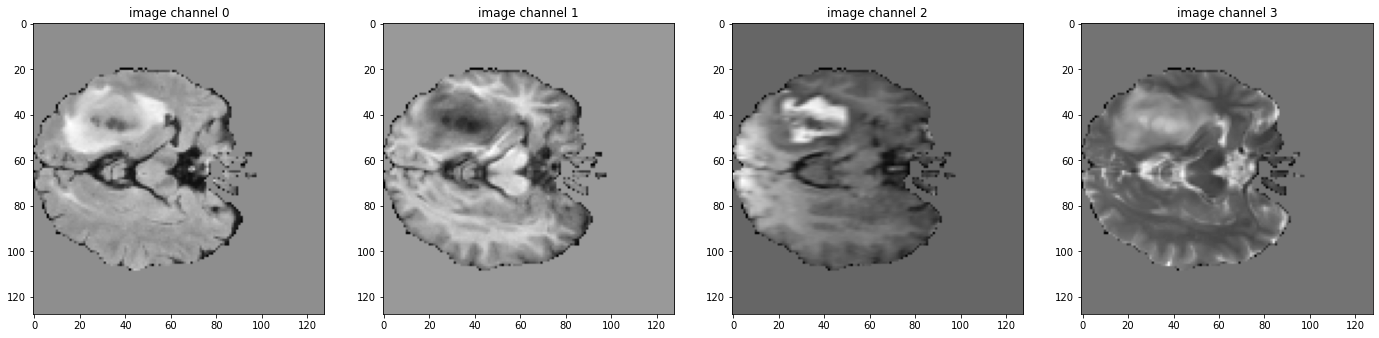

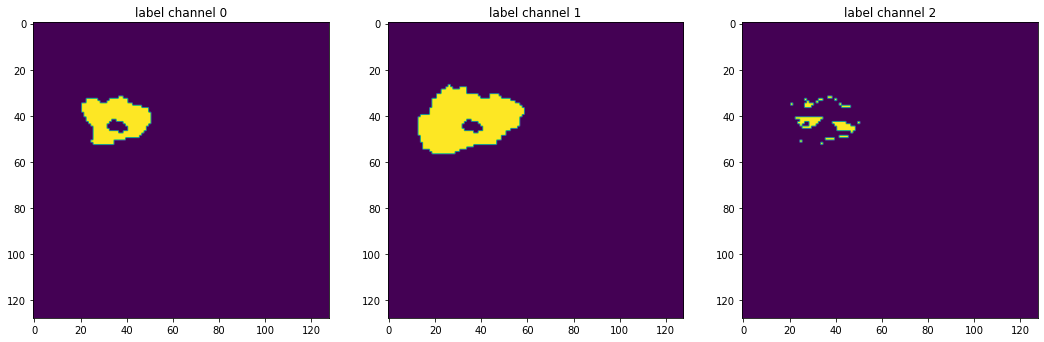

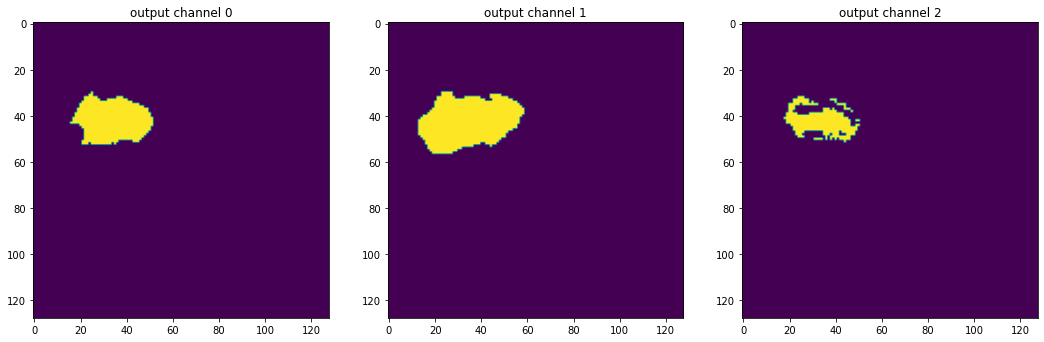

########################################
Example: BRATS_226.nii.gz



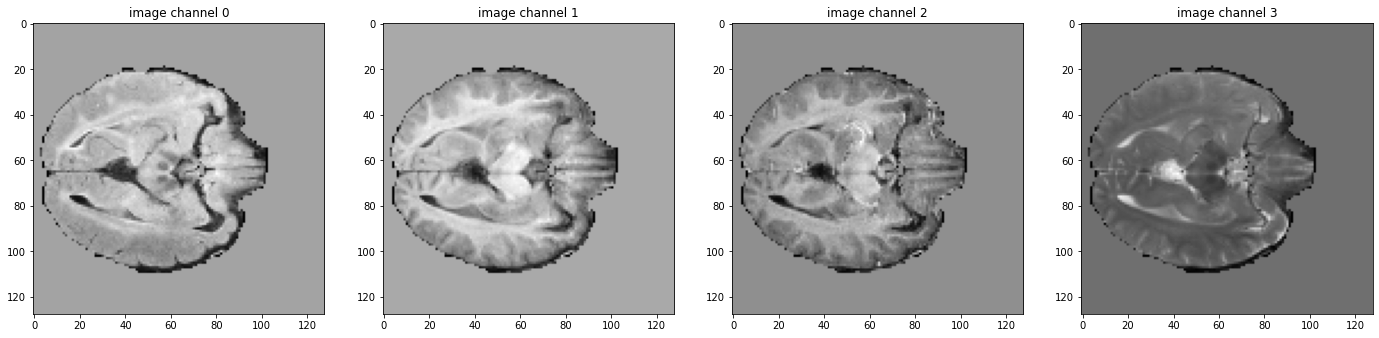

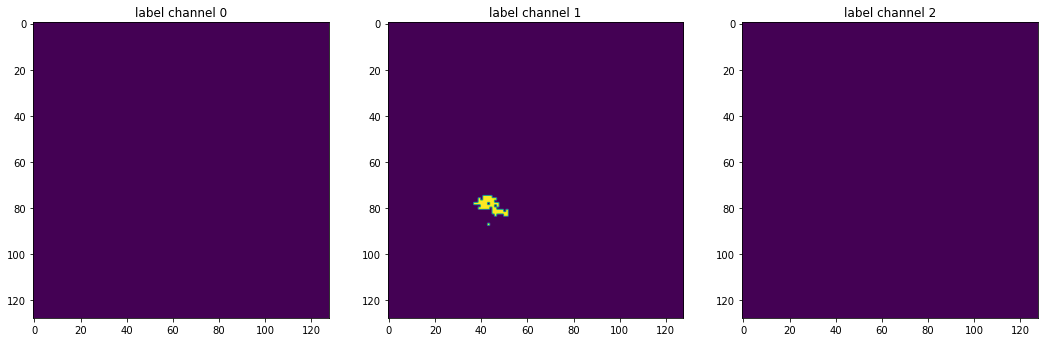

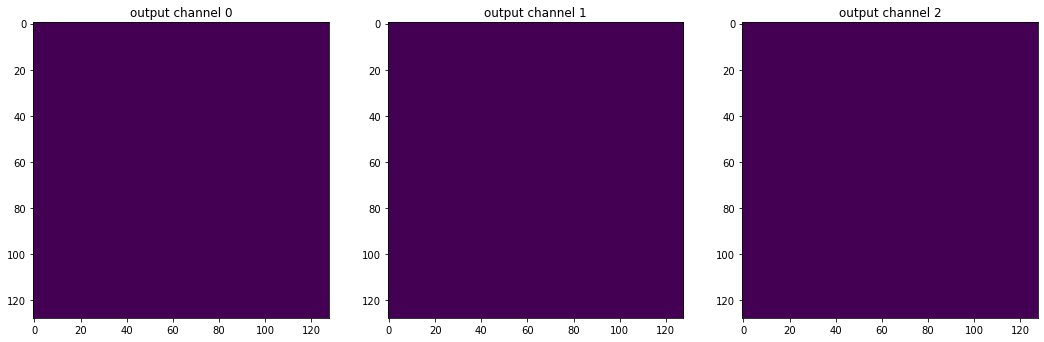

########################################
Example: BRATS_082.nii.gz



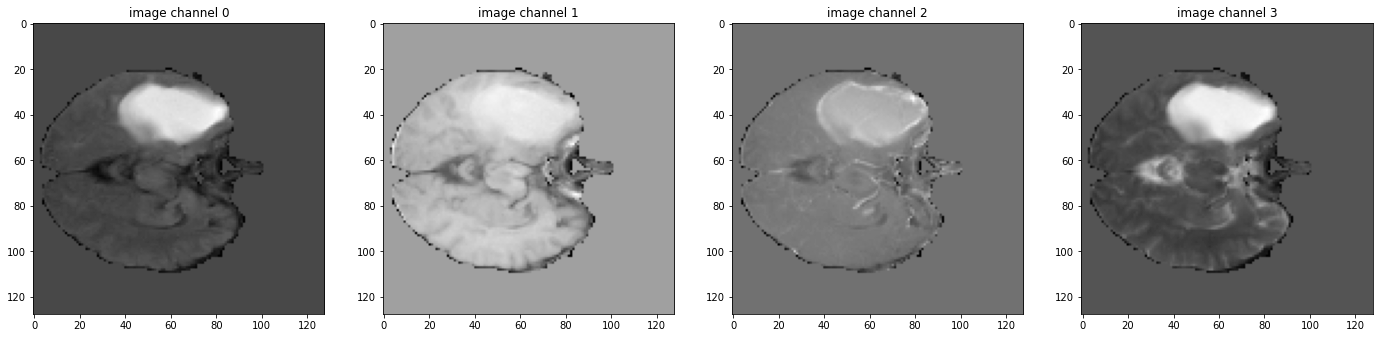

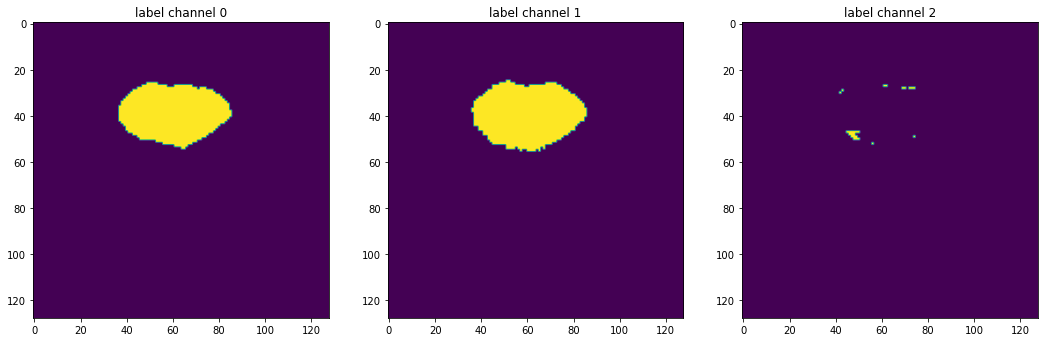

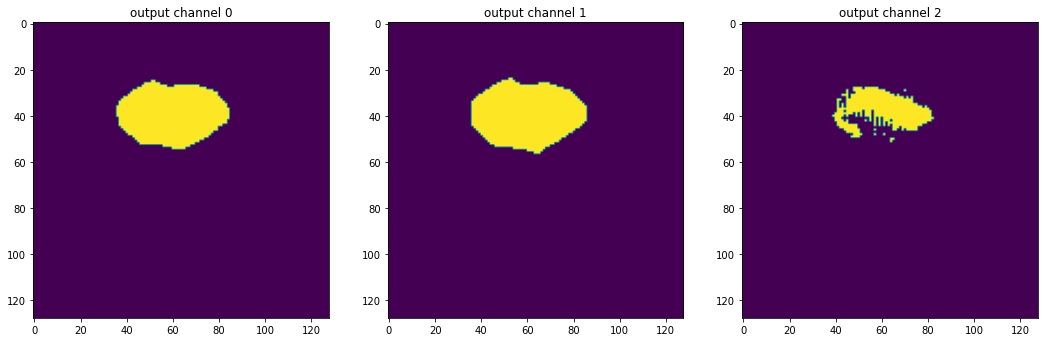

########################################
Example: BRATS_462.nii.gz



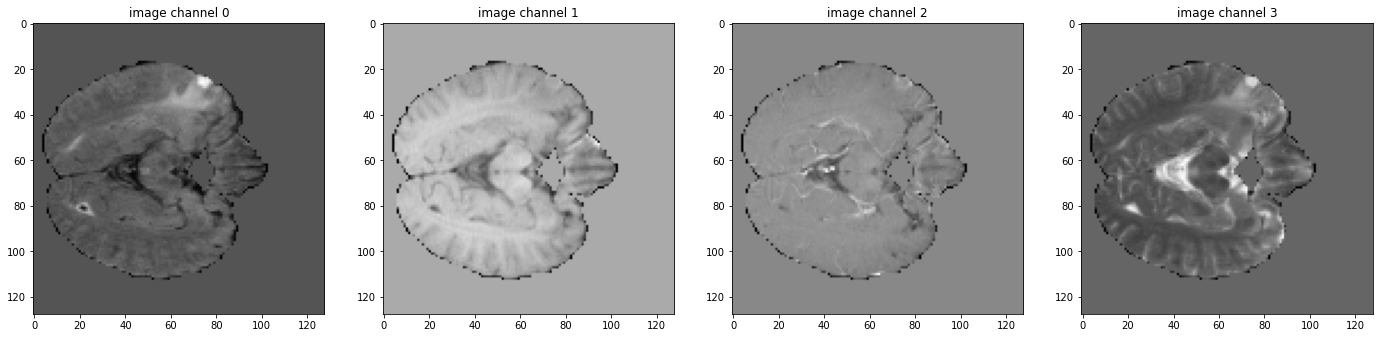

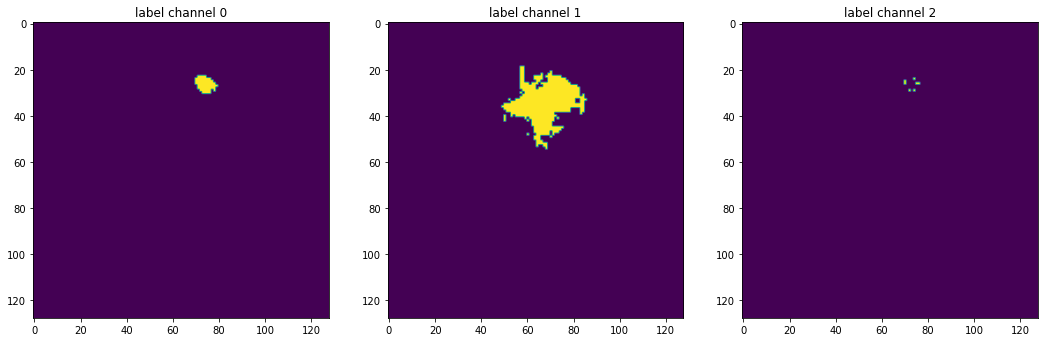

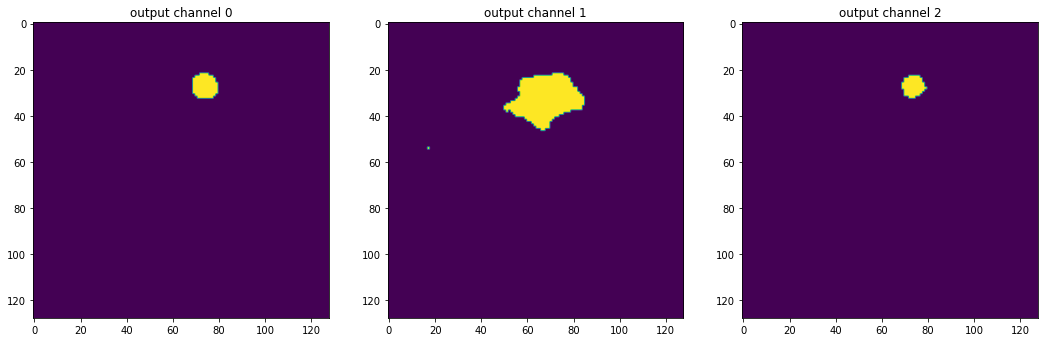

########################################


In [71]:
k=4
for ds in random.choices(range(len(val_ds)), k=k):
    fn = val_ds[ds]['image_meta_dict']['filename_or_obj'].split("/")[-1]
    print(f"Example: {fn}\n")
    plot_preds(ds)
    print("#"*40)

# Note

MONAI has a bunch of great features (https://monai.io), but some of the neat tricks we looked at in the notebooks based on fastai aren't implemented. 

That's one reason why our PhD student [Sathiesh](https://skaliy.no/) is currently developing the **fastMONAI** framework combining features from fastai with MONAI:

<img src="assets/fastmonai.png">

fastMONAI has been used in the following papers, and is currently being used in multiple ongoing projects.
* [Fully Automatic Whole-Volume Tumor Segmentation in Cervical Cancer](https://www.mdpi.com/2072-6694/14/10/2372), Hodneland, E, Kaliyugarasan, S, et al., Cancers 14(10), 2022
* [Pulmonary nodule classification in lung cancer from 3D thoracic CT scans using fastai and MONAI](https://www.ijimai.org/journal/bibcite/reference/2944), S. Kaliyugarasan, A. Lundervold and A.S. Lundervold. IJIMAI, vol. 6, no. 7, 2021.
* [2D and 3D U-Nets for skull stripping in a large and heterogeneous set of head MRI using fastai](https://ojs.bibsys.no/index.php/NIK/article/view/836), Kaliyugarasan S, Kocinski M, Lundervold A, Lundervold AS., NIK2020, no.1, 2020.

<small>https://github.com/skaliy/fastMONAI/blob/master/nbs_dev/06a_multiclass_multimodal_segmentation.ipynb </small>

### TorchIO

As discussed in the lecture, domain-specific data augmentation is in general a very good idea. The library [TorchIO](https://torchio.readthedocs.io/) provides a set of augmentation techniques tailored for medical imaging. For a challenge, you can try to use the information in the notebook `2.2.3-asl-data-augmentation_medical-imaging.ipynb` together with the above MONAI example to use additional data augmentation methods in the above setup. 

## Medical Segmentation Decathlon

There are more data sets in the Medical Segmentation Decathlon. See if you can construct a model for one of the other data sets.

# What's next?

Once you have extracted the tumor ROIs it's possible to quantify tumor size, shape and localization, as well as derive _radiomic_ features related to texture and the like. Have a look at [PyRadiomics](https://pyradiomics.readthedocs.io/en/latest/) to get a feeling for a possible way forward.